<a href="https://colab.research.google.com/github/PranavBansal7/AIMLkanpur/blob/main/GNN_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torch-geometric pandas scikit-learn matplotlib tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.0 MB/s eta 0:00:00


In [2]:
from google.colab import files
import pandas as pd

print("📂 Please upload your Kanpur, Unnao, and Bithur CSV files (with 'time' and 'pm2_5' columns).")
uploaded = files.upload()

dataframes = {}

# Load CSVs into dictionary
for filename in uploaded.keys():
    try:
        df = pd.read_csv(filename)
        dataframes[filename.split('.')[0].lower()] = df
        print(f"✅ Loaded {filename} → shape {df.shape}")
        print("   Columns:", df.columns.tolist())
    except Exception as e:
        print(f"⚠️ Error loading {filename}: {e}")

# Safely fetch datasets regardless of file name endings like '.csv.csv'
kanpur = next((v for k, v in dataframes.items() if "kanpur" in k), None)
unnao = next((v for k, v in dataframes.items() if "unnao" in k), None)
bithur = next((v for k, v in dataframes.items() if "bithur" in k), None)

# Validation
missing = [name for name, df in zip(["kanpur", "unnao", "bithur"], [kanpur, unnao, bithur]) if df is None]
if missing:
    print(f"\n❌ Missing datasets: {', '.join(missing)}")
else:
    print("\n✅ All datasets loaded successfully!")


📂 Please upload your Kanpur, Unnao, and Bithur CSV files (with 'time' and 'pm2_5' columns).


Saving bithur.csv.csv to bithur.csv.csv
Saving kanpur.csv.csv to kanpur.csv.csv
Saving unnao.csv.csv to unnao.csv.csv
✅ Loaded bithur.csv.csv → shape (28440, 2)
   Columns: ['time', 'pm2_5']
✅ Loaded kanpur.csv.csv → shape (28440, 2)
   Columns: ['time', 'pm2_5']
✅ Loaded unnao.csv.csv → shape (28440, 2)
   Columns: ['time', 'pm2_5']

✅ All datasets loaded successfully!


In [19]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# ✅ Clean and prepare datasets
for df in [kanpur, unnao, bithur]:
    df['time'] = pd.to_datetime(df['time'], errors='coerce')
    df = df.sort_values('time')
    df.dropna(subset=['pm2_5'], inplace=True)
    df['pm2_5'] = df['pm2_5'].astype(float)

# ✅ Align all datasets on time
merged_df = pd.concat([
    kanpur.set_index('time')['pm2_5'].rename('kanpur'),
    unnao.set_index('time')['pm2_5'].rename('unnao'),
    bithur.set_index('time')['pm2_5'].rename('bithur')
], axis=1)

# Fill missing values
merged_df = merged_df.interpolate(method='time').dropna()

print("✅ Merged dataset shape:", merged_df.shape)
print(merged_df.head())

# 🔹 SCALE THE DATA (important for GNN training)
scaler_kanpur = MinMaxScaler()
scaler_unnao = MinMaxScaler()
scaler_bithur = MinMaxScaler()

# Fit and transform each city column separately
merged_df['kanpur_scaled'] = scaler_kanpur.fit_transform(merged_df[['kanpur']])
merged_df['unnao_scaled'] = scaler_unnao.fit_transform(merged_df[['unnao']])
merged_df['bithur_scaled'] = scaler_bithur.fit_transform(merged_df[['bithur']])

# Use scaled data for training
data_scaled = merged_df[['kanpur_scaled', 'unnao_scaled', 'bithur_scaled']].values

print("\n✅ Individual scaling done for each city.")
print(merged_df.head())


✅ Merged dataset shape: (28440, 3)
                     kanpur  unnao  bithur
time                                      
2022-08-16 00:00:00    13.5   13.5    16.0
2022-08-16 01:00:00    12.5   12.5    15.1
2022-08-16 02:00:00    12.0   12.0    13.9
2022-08-16 03:00:00    11.4   11.4    13.2
2022-08-16 04:00:00    10.5   10.5    12.0

✅ Individual scaling done for each city.
                     kanpur  unnao  bithur  kanpur_scaled  unnao_scaled  \
time                                                                      
2022-08-16 00:00:00    13.5   13.5    16.0       0.050310      0.050310   
2022-08-16 01:00:00    12.5   12.5    15.1       0.046440      0.046440   
2022-08-16 02:00:00    12.0   12.0    13.9       0.044505      0.044505   
2022-08-16 03:00:00    11.4   11.4    13.2       0.042183      0.042183   
2022-08-16 04:00:00    10.5   10.5    12.0       0.038700      0.038700   

                     bithur_scaled  
time                                
2022-08-16 00:00:00   

In [12]:
!pip install torch torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user


In [20]:
# Convert merged_df to torch tensors
X = torch.tensor(merged_df.values, dtype=torch.float32)

# Normalize (optional but helps training)
X = (X - X.mean(dim=0)) / X.std(dim=0)

# Adjacency (fully connected: each city connected to every other)
edge_index = torch.tensor([
    [0, 0, 1, 1, 2, 2],
    [1, 2, 0, 2, 0, 1]
], dtype=torch.long)

# We’ll use first 80% for training, last 20% for testing
train_size = int(0.8 * len(X))
train_X, test_X = X[:train_size], X[train_size:]

# Shifted target (predict next-time PM2.5 for Kanpur)
train_y = train_X[1:, 0]  # next time step Kanpur
train_X = train_X[:-1]

test_y = test_X[1:, 0]
test_X = test_X[:-1]

print("Train shapes:", train_X.shape, train_y.shape)
print("Test shapes:", test_X.shape, test_y.shape)

Train shapes: torch.Size([22751, 6]) torch.Size([22751])
Test shapes: torch.Size([5687, 6]) torch.Size([5687])


In [21]:
class GNNPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNPredictor, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.relu = nn.ReLU()
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GNNPredictor(in_channels=train_X.shape[1], hidden_channels=8, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

model.train()
for epoch in range(200):
    optimizer.zero_grad()

    # Forward pass on training data (node features)
    out = model(train_X.to(device), edge_index.to(device))
    loss = criterion(out[:, 0], train_y.to(device))

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/200], Loss: {loss.item():.4f}")


Epoch [20/200], Loss: 0.0789
Epoch [40/200], Loss: 0.0556
Epoch [60/200], Loss: 0.0470
Epoch [80/200], Loss: 0.0433
Epoch [100/200], Loss: 0.0413
Epoch [120/200], Loss: 0.0399
Epoch [140/200], Loss: 0.0388
Epoch [160/200], Loss: 0.0379
Epoch [180/200], Loss: 0.0370
Epoch [200/200], Loss: 0.0356


In [27]:
model.eval()
with torch.no_grad():
    preds = model(test_X.to(device), edge_index.to(device))[:, 0].cpu().numpy()

actual = test_y.numpy()

mae = mean_absolute_error(actual, preds)
rmse = np.sqrt(mean_squared_error(actual, preds))
mape = np.mean(np.abs((actual - preds) / actual)) * 100
r2 = r2_score(actual, preds)

print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.3f}")

MAE:  0.089
RMSE: 0.135
MAPE: 73.69%
R²:   0.954


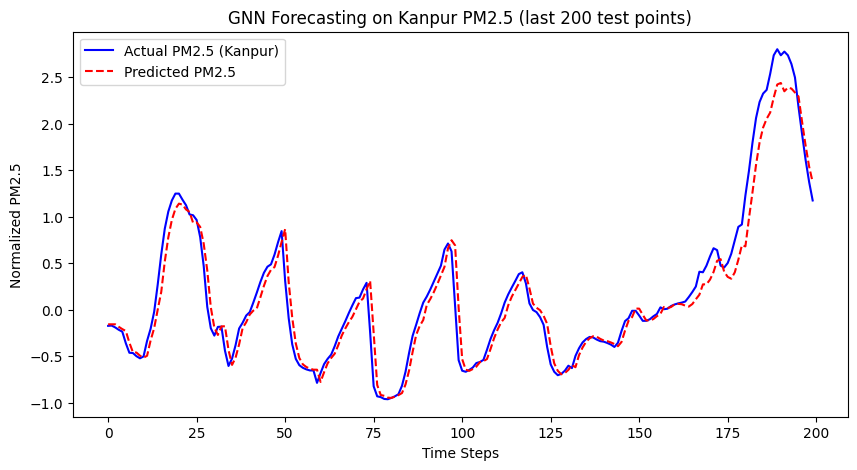

In [28]:
plt.figure(figsize=(10,5))
plt.plot(actual[:200], label='Actual PM2.5 (Kanpur)', color='blue')
plt.plot(preds[:200], label='Predicted PM2.5', color='red', linestyle='--')
plt.title("GNN Forecasting on Kanpur PM2.5 (last 200 test points)")
plt.xlabel("Time Steps")
plt.ylabel("Normalized PM2.5")
plt.legend()
plt.show()
